# import

In [1]:
import os
import re
import pandas as pd
from utils import *

# 0. Load data

In [2]:
# author code
x_tr_df = pd.read_csv('train_folder/x_train_ids.csv', index_col=0)
tr_dir = "train_folder/txt_files/"
tr_files = x_tr_df['filename'].values


tr_texts = []
for tr_file in tr_files:
    f = open(os.path.join(tr_dir, tr_file), "r")
    ff = f.read()
    ff = clean1(ff)
    tr_texts.append(ff)
# tr_texts has all the texts in it

In [3]:
#y_train data
y_tr_df = pd.read_csv('train_folder/Y_train_predilex.csv', index_col=0)

In [4]:
y_tr_df.head()

,sexe,date_accident,date_consolidation
ID,,,
0,homme,1991-04-09,n.c.
1,homme,2005-06-10,2010-01-19
2,femme,1997-09-26,n.c.
3,femme,1982-08-07,1982-11-07
4,homme,1996-11-26,n.c.


# 1. Find all possible patterns for dates

In [7]:
# all index of the year of the accident 
all_dates = []
for i in range(len(tr_texts)):
    if y_tr_df['date_accident'][i] != 'n.c.':
        ff = [m.start() for m in re.finditer(y_tr_df['date_accident'][i][:4], tr_texts[i])]
    else:
        ff = []
    all_dates.append(ff)

In [8]:
# check if there is the day digit near the year digit
sentences = []
for ind in range(len(tr_texts)):
    sentence = []
    window = 20
    for date in all_dates[ind]:
        left = tr_texts[ind][date - window : date]
        right = tr_texts[ind][date + 4 : date + window]
        left_num = re.findall(r'\d', left)
        right_num = re.findall(r'\d', right)
        if len(left_num) == 0 & len(right_num) == 0:
            pass
        else:
            text = tr_texts[ind][date - window : date + window]
            sentence.append(text)
    sentences.append(sentence)

In [5]:
# find all pattern of dates
pattern1 = r"\d{1,} \w{3,9} \d{4}"
pattern2 = r"1° \w{3,9} \d{4}"
pattern3 = r"1er \w{3,9} \d{4}"
pattern4 = r"\d{1,}\.\d{2}\.\d{4}"
pattern5 = r"\d{1,}/\d{2}/\d{4}"
pattern6 = r"\d{1,} / \d{2} / \d{4}"
pattern7 = r"\d{1,}/ \d{2}/ \d{4}"
pattern8 = r"\d{1,}\. \d{2}\. \d{4}"


pattern1_bis = r"(\d{1,}) (\w{3,9}) (\d{4})"
pattern2_bis = r"(1°) (\w{3,9}) (\d{4})"
pattern3_bis = r"(1er) (\w{3,9}) (\d{4})"
pattern4_bis = r"(\d{1,})\.(\d{2})\.(\d{4})"
pattern5_bis = r"(\d{1,})/(\d{2})/(\d{4})"
pattern6_bis = r"(\d{1,}) / (\d{2}) / (\d{4})"
pattern7_bis = r"(\d{1,})/ (\d{2})/ (\d{4})"
pattern8_bis = r"(\d{1,})\. (\d{2})\. (\d{4})"

patterns = [pattern1, pattern2, pattern3, pattern4, pattern5, pattern6, pattern7, pattern8] 
patterns_bis = [pattern1_bis, pattern2_bis, pattern3_bis, pattern4_bis, pattern5_bis, pattern6_bis, pattern7_bis, pattern8_bis] 

In [10]:
# check the number of sentences that doesnt get detected using preious patterns
dates = []
fails = []
for i in range(len(sentences)):
    date = []
    index = []
    for sentence in sentences[i]:
        l = []
        for pattern in patterns:
            l.extend(re.findall(pattern, sentence))
        if len(l) == 0:
            fails.append(sentence)
        date.extend(l)
    dates.append(date)

In [11]:
len(fails)

71

In [18]:
fails

['9 cour d’appel d’agen audience publique ',
 '00908 republique francaise au nom du peu',
 ' 47910 agen cedex 9 n’ayant pas constitu',
 ' ordonnance 99-xxxx 1999-04-21 art. 1 ',
 '2 : 30. 321,00 € en 2003 : 48. 778,00 € ',
 'rance au 1o juillet 2003 il convient de ',
 'mpter du 1o juillet 2003 jusqu’au 27 aoû',
 'de juin 2000 à août 2002 (7. 447 € 66 c.',
 '/1960 republique francaise au nom du peu',
 '; 3o) à chacun des enfants jean pierre, ',
 'mai 2006 ; vu l’ordonnance de clôture en',
 'e 11 années en se fondant sur les conclu',
 '03 + 11.115,01 € en 2004) correspondant ',
 '01 et le 1o juillet 2004 des indemnités ',
 'ral sous le no 05 / 2003. appelante mada',
 '000 au mois d’avril 2001 ne permet pas à',
 'il 1998 (et non pas 1997 comme indiqué p',
 '41 €) et l’exercice 2006 (181. 527 €) qu',
 'janvier 2008 et mai 2000 ; il convient d',
 ' 2009 n° de rg: 08/02006 republique fran',
 'no/2009 rôle no 08/02006 fonds de garant',
 ' juin 2010. une ordonnance de jonction a',
 ' étant de 

# 2. Creating Training Set

In [6]:
import nltk
from tqdm import tqdm
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/fei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/fei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stemmer = SnowballStemmer('french')
lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('french'))

In [8]:
months_str_to_int = dict(janvier='01', fevrier='02', mars='03', avril='04', mai='05', juin='06',
                         juillet='07', aout='08', septembre='09', octobre='10', novembre='11',
                         decembre='12')

def format_date(day:str, month:str):
    if len(day) == 1:
        day = '0' + day
    if not month.isnumeric():
        month = months_str_to_int[month]
    elif len(month) == 1:
        month = '0' + month
    return day, month

In [23]:
x_train = []
y_train = []
for i in tqdm(range(len(tr_texts))):
    if y_tr_df.iloc[i]['date_accident'] != 'n.c.':
        text = tr_texts[i]
        index = []
        dates = []
        for k, pattern in enumerate(patterns):
            index.extend(re.finditer(pattern, text))
            dates.extend(re.findall(patterns_bis[k], text))

        window = 50
        for k, ind in enumerate(index):
            if dates[k]:
                day, month, year = dates[k][0], dates[k][1], dates[k][2]
                month = month.lower().replace('é', 'e').replace('û', 'u')
                if (month in months_str_to_int) or (month in months_str_to_int.values()):
                    day, month = format_date(day, month)
                    date = f"{year}-{month}-{day}"
                    chunk = text[ind.start() - window: ind.end() + window]
                    chunk = clean2(chunk, lemmatizer, stemmer, stop_words = stop_words)
                    x_train.append(chunk)

                    if date == y_tr_df.iloc[i]['date_accident']: y_train.append(1)
                    else: y_train.append(0)
        

100%|██████████| 770/770 [00:23<00:00, 32.98it/s]


In [26]:
y_train = np.array(y_train)

In [48]:
num_pos = len([i for i in y_train if i == 1])
num_neg = len([i for i in y_train if i == 0])
scale_pos_weight = 1

# 3. Training Model

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from xgboost import XGBClassifier

In [29]:
TF_IDF = TfidfVectorizer(ngram_range=(1, 2), max_features=100, norm='l2', sublinear_tf=True)
x_train = TF_IDF.fit_transform(x_train).toarray()

In [49]:
random_state = 42

param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [.1],
    'subsample': [.7, .9],
    'colsample_bytree': [.7, .9],
}
classifier, best_thresh, best_params = grid_search(x_train, y_train, param_grid)

In [50]:
classifier.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.7, tree_method=None,
              validate_parameters=False, verbosity=None)

In [90]:
proba = classifier.predict_proba(x_train)

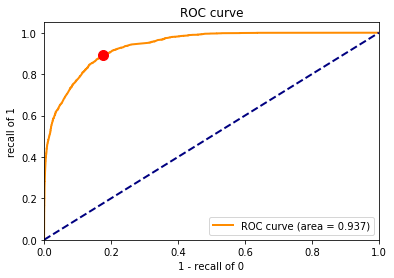

optimal threshold is 0.0751425102353096


In [93]:
t, _ = find_opti_thresh(y_train, proba[:,1])

# 4. Predict accident date in a text

In [51]:
candidates = []
sentence_dates = []
true_dates = []
for i in tqdm(range(len(tr_texts))):
    if y_tr_df.iloc[i]['date_accident'] != 'n.c.':
        text = tr_texts[i]
        index = []
        dates = []
        for k, pattern in enumerate(patterns):
            index.extend(re.finditer(pattern, text))
            dates.extend(re.findall(patterns_bis[k], text))

        window = 50
        data = []
        s_d = []
        for k, ind in enumerate(index):
            if dates[k]:
                day, month, year = dates[k][0], dates[k][1], dates[k][2]
                month = month.lower().replace('é', 'e').replace('û', 'u')
                if month in months_str_to_int or month in months_str_to_int.values():
                    day, month = format_date(day, month)
                    date = f"{year}-{month}-{day}"
                    chunk = text[ind.start() - window: ind.end() + window]
                    chunk = clean2(chunk, lemmatizer, stemmer, stop_words = stop_words)
                    data.append(chunk)
                    s_d.append(date)

        candidates.append(data)
        sentence_dates.append(s_d)
        true_dates.append(y_tr_df.iloc[i]['date_accident'])

100%|██████████| 770/770 [00:19<00:00, 40.18it/s]


In [52]:
for i in range(len(candidates)):
    candidate = TF_IDF.transform(candidates[i]).toarray()
    candidates[i] = candidate

In [55]:
preds = []
L = []
for i, candidate in enumerate(candidates):
    out = classifier.predict_proba(candidate)[:,1]
    pred = np.argmax(out)
    score = np.max(out)
    pred_date = sentence_dates[i][pred]
    preds.append(pred_date)
    if score < 0.2: L.append((score, i, pred))

In [56]:
accuracy = 0
for i in range(len(preds)):
    if preds[i] == true_dates[i]:
        accuracy += 1
accuracy/len(preds)

0.7375504710632571

## 4.1 checking errors

In [ ]:
# 14/11/99 not detected
# sentence not explicitly stating accident or not long enough

In [68]:
d = re.finditer('accident', tr_texts[6])

In [70]:
ee = next(d)
s,e = ee.start(), ee.end()

In [73]:
tr_texts[6][s-50:e+50]

'paration intégrale du préjudice que lui a causé l’accident du 14/11/99 impliquant le véhicule terrestre à mo'

In [79]:
true_dates[11]

'2000-07-13'

In [78]:
candidates[11]

['ppel d’agen chambre civile 1 audience publique du 21 novembre 2007 n° de rg: 06/00604 republique francaise au nom du',
 'ique francaise au nom du peuple francais arrêt du 21 novembre 2007 d.n / s.b ---------------------- rg n : 06 / 0060',
 ' dans l’affaire, entre : madame saliha xxx née le 28 août 1956 à mirabeau (algerie) ... ... représentée par la s',
 ' le tribunal de grande instance d’agen en date du 23 février 2006 d’une part, et : monsieur amar yyy né le 24 octob',
 'ier 2006 d’une part, et : monsieur amar yyy né le 24 octobre 1983 à orthez (64300) de nationalité française ... ...',
 'alain miranda, avocat monsieur richard z... né le 28 mars 1946 à perigueux (24) de nationalité française, profes',
 'urdin, avocat madame marie a...épouse z... née le 22 avril 1957 à bourg de visa (82190) de nationalité française ',
 ' été débattue et plaidée en audience publique, le 10 octobre 2007, devant bernard boutie, président de chambre, dom',
 'uelle l’arrêt serait rendu. * * * par jugeme

In [35]:
L

[(0.17186923, 0, 5),
 (0.012502044, 1, 22),
 (0.04119774, 4, 19),
 (0.026311059, 6, 5),
 (0.01857293, 7, 12),
 (0.010447117, 10, 7),
 (0.011538391, 11, 9),
 (0.19259576, 18, 21),
 (0.04508364, 28, 21),
 (0.13627471, 29, 15),
 (0.09596507, 34, 18),
 (0.008233897, 35, 17),
 (0.016996022, 42, 18),
 (0.0108090425, 46, 15),
 (0.017691512, 47, 21),
 (0.14154074, 48, 12),
 (0.035917185, 50, 18),
 (0.04470571, 51, 11),
 (0.097651534, 57, 24),
 (0.007261441, 66, 18),
 (0.016930977, 67, 15),
 (0.1613709, 69, 10),
 (0.13627471, 72, 19),
 (0.10741988, 82, 11),
 (0.032652672, 86, 31),
 (0.008462342, 89, 12),
 (0.019054228, 105, 10),
 (0.18061611, 111, 13),
 (0.05472689, 112, 19),
 (0.102939196, 115, 37),
 (0.01912584, 119, 32),
 (0.022299036, 123, 8),
 (0.09545197, 133, 8),
 (0.02780699, 136, 15),
 (0.016418597, 137, 8),
 (0.09545197, 138, 8),
 (0.18078548, 139, 50),
 (0.029791573, 141, 8),
 (0.08474846, 146, 14),
 (0.04478941, 148, 15),
 (0.012698163, 150, 16),
 (0.03216976, 156, 30),
 (0.01447154

#  3. Predict test data 

In [59]:
#x_test data
x_te_df = pd.read_csv('test_folder/x_test_ids.csv', index_col=0)
te_dir = "test_folder/txt_files/"
te_files = x_te_df['filename'].values
te_texts = []
for te_file in te_files:
    f = open(os.path.join(te_dir, te_file), "r")
    ff = f.read()
    ff = clean1(ff)
    te_texts.append(ff)

In [60]:
candidates = []
sentence_dates = []
for i in tqdm(range(len(te_texts))):
    text = te_texts[i]
    index = []
    dates = []
    for k, pattern in enumerate(patterns):
        index.extend(re.finditer(pattern, text))
        dates.extend(re.findall(patterns_bis[k], text))

    window = 50
    data = []
    s_d = []
    for k, ind in enumerate(index):
        if dates[k]:
            day, month, year = dates[k][0], dates[k][1], dates[k][2]
            month = month.lower().replace('é', 'e').replace('û', 'u')
            if month in months_str_to_int:
                day, month = format_date(day, month)
                date = f"{year}-{month}-{day}"
                chunk = text[ind.start() - window: ind.end() + window]
                chunk = clean2(chunk, lemmatizer, stemmer, stop_words = stop_words)
                data.append(chunk)
                s_d.append(date)

    candidates.append(data)
    sentence_dates.append(s_d)

100%|██████████| 257/257 [00:06<00:00, 41.06it/s]


In [61]:
for i in range(len(candidates)):
    candidate = TF_IDF.transform(candidates[i]).toarray()
    candidates[i] = candidate

In [62]:
#ajouter n.c.

In [63]:
preds = []
for i, candidate in enumerate(candidates):
    pred = np.argmax(classifier.predict_proba(candidate)[:,1])
    pred_date = sentence_dates[i][pred]
    preds.append(pred_date)

In [64]:
np.save('results/accident.npy', preds)

In [48]:
preds[2]

'1989-05-11'

In [49]:
candidates[2]

['/11/2019 cour d’appel d’agen audience publique du 10 février 2004 n° de rg: 02/1013 republique francaise au nom du ',
 'republique francaise au nom du peuple francais du 10 février 2004 ------------------------- c.s/s.b s.a. axa assura',
 ' le tribunal de grande instance d’agen en date du 14 juin 2002 d’une part, et : madame francine xxx représentée ',
 'lic, débattue et plaidée en audience publique, le 09 décembre 2003, devant nicole roger, présidente de chambre, cath',
 'né par ordonnance du premier président en date du 05 mars 2003, assistés de dominique saley, greffière, et qu’il',
 'cédure, des moyens et prétentions des parties. le 11 mai 1989, francine xxx a été victime d’un accident de la c',
 '430. elle a subi par ailleurs une intervention le 10 juillet 1989 ainsi qu’une ostéosynthèse de l’humérus avec gref',
 'produits contaminés par ce virus. par courrier du 8 août 1995 le cits d’agen, par l’intermédiaire du docteur a.',
 'étaient hcv positifs. par ordonnance de référé du 2